In [1]:
classification_names = {
    0: '上身衣服',  # 数字 0 对应“上身衣服”
    1: '鞋',       # 数字 1 对应“鞋”
    2: '包',       # 数字 2 对应“包”
    3: '下身衣服',  # 数字 3 对应“下身衣服”
    4: '手表'      # 数字 4 对应“手表”
}

In [2]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader,random_split
from PIL import Image
import re
import pandas as pd

In [3]:
# 对文件名进行转换----对文件名进行排序
def sorted_alphanum(img_names):
    convert = lambda x: int(x) if x.isdigit() else x.lower()
    alphanum_key = lambda img_name: [convert(c) for c in re.split('([0-9]+)', img_name)]
    return sorted(img_names, key=alphanum_key)


# 自定义数据集类型
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.main_dir = image_dir
        self.transform = transform
        self.image_names = sorted_alphanum(os.listdir(image_dir))  # 获取目录下所有图片文件名，保存为列表
        self.labels=pd.read_csv('../common/fashion-labels.csv')#读取标签
        self.label_dict=dict(zip(self.labels['id'],self.labels['target']))#创建标签字典

    def __len__(self):
        return len(self.image_names)

    # 传入图片id。获取数据集元素，返回图片和标签
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        # 构建完整图片路径
        image_path = os.path.join(self.main_dir, image_name)
        # 打开图片
        image = Image.open(image_path).convert('RGB')  # 图片自带一个透明色(RGBA)，即四个维度，转为三维
        if self.transform is not None:
            tensor_image = self.transform(image)  # 范围在0-1之间
        else:  # 如果没有定义转换，引出异常
            raise ValueError('No transform')
        #在字典中找到图片对应的标签
        label=self.label_dict[idx]
        # 返回噪声图片和原始图片
        return tensor_image, label


In [4]:
#测试主流程
import torchvision.transforms as transforms
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')#获取设备
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

#创建数据集
full_dataset=ImageLabelDataset(image_dir='../common/dataset/',transform=transform)
# print('数据集大小：',len(full_dataset))

In [5]:
#划分数据集
train_dataset,test_dataset=random_split(full_dataset,[0.75,0.25])#把数据集75%作为训练集25%作为测试集


In [7]:
from torch.utils.data import DataLoader
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)#丢掉最后一批（一般达不到一批次的数量）的数据集
test_loader=DataLoader(test_dataset,batch_size=batch_size)#测试集

In [8]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [15]:
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,n_classes=5):
        super().__init__()
        self.conv1=nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.linear=nn.Linear(4096,n_classes)
    def forward(self,x):
        x=torch.relu(self.conv1(x))
        x=self.pool(x)
        # print(f"第二层输出：{x.shape}")
        x=torch.relu(self.conv2(x))
        # print(f"第三层输出：{x.shape}")
        x=self.pool(x)
        # print(f"第四层输出：{x.shape}")
        x=x.reshape(x.shape[0],-1)
        # print(f"第五层输入：{x.shape}")
        x=self.linear(x)
        # print(f"第六层输出：{x.shape}")
        return x

In [16]:
model=ClassificationModel()
# print(model)

In [17]:
# data_iter=iter(train_loader)
# x,y=next(data_iter)
# print(x.shape,y.shape)
# out=model(x)
# print(out.shape)

In [18]:
#训练
import torch.optim as optim
from tqdm import tqdm
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
model.to(device)
epochs=10
for epoch in range(1,epochs+1):
    total_loss=0.0
    for x,y in tqdm(train_loader):
        # 切换设备
        x,y=x.to(device),y.to(device)
        # 前向传播
        output=model(x)
        # 计算损失
        loss=criterion(output,y)
        total_loss+=loss.item()
        # 反向传播+更新参数+清零梯度
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch:{epoch}/10  Loss:{total_loss/len(train_loader)}")

        

100%|██████████| 582/582 [00:23<00:00, 24.81it/s]


Epoch:1/10  Loss:0.2540204698040672


100%|██████████| 582/582 [00:14<00:00, 40.71it/s]


Epoch:2/10  Loss:0.08046317787835362


100%|██████████| 582/582 [00:14<00:00, 40.94it/s]


Epoch:3/10  Loss:0.06172601407921083


100%|██████████| 582/582 [00:14<00:00, 40.40it/s]


Epoch:4/10  Loss:0.0522047959730554


100%|██████████| 582/582 [00:15<00:00, 37.98it/s]


Epoch:5/10  Loss:0.046364992803147285


100%|██████████| 582/582 [00:15<00:00, 38.78it/s]


Epoch:6/10  Loss:0.03782368200288844


100%|██████████| 582/582 [00:14<00:00, 40.09it/s]


Epoch:7/10  Loss:0.03348666536261202


100%|██████████| 582/582 [00:14<00:00, 40.91it/s]


Epoch:8/10  Loss:0.027646889709763024


100%|██████████| 582/582 [00:14<00:00, 40.83it/s]


Epoch:9/10  Loss:0.026313050624381797


100%|██████████| 582/582 [00:14<00:00, 40.95it/s]

Epoch:10/10  Loss:0.02041494784644936


In [19]:
loader_iter=iter(test_loader)
x,y=next(loader_iter)
model=model.to(device)
x=x.to(device)
output=model(x)
output=output.detach().cpu().numpy()
x=x.permute(0,2,3,1).cpu().detach().numpy()
print(output.shape,x.shape)

(32, 5) (32, 64, 64, 3)


1-label:下身衣服
1-output:下身衣服
2-label:上身衣服
2-output:上身衣服
3-label:下身衣服
3-output:下身衣服
4-label:鞋
4-output:鞋
5-label:上身衣服
5-output:上身衣服
6-label:上身衣服
6-output:上身衣服
7-label:包
7-output:包
8-label:上身衣服
8-output:上身衣服
9-label:鞋
9-output:鞋
10-label:上身衣服
10-output:上身衣服


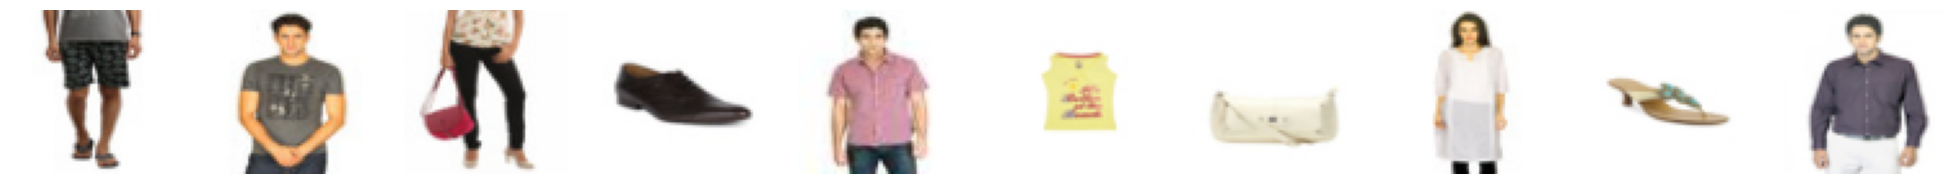

In [21]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,10,figsize=(25,4))
for i,ax in enumerate(axes):
    ax.imshow(x[i])
    ax.axis('off')
    #打印真是标签
    print(f"{i+1}-label:{classification_names[int(y[i])]}")
    #打印预测标签
    class_pred=np.argmax(output[i])
    print(f"{i+1}-output:{classification_names[class_pred]}")
plt.show()

In [22]:
#计算准确率
test_correct_num=0
with torch.no_grad():
    for x,y in test_loader:
        x,y=x.to(device),y.to(device)
        output=model(x)
        pred=torch.argmax(output,dim=1)
        test_correct_num+=(pred==y).sum()
print(f"准确率：{test_correct_num/len(test_dataset)}")

准确率：0.9868018627166748
